# Text Mining – Predicting Stock Price Direction

### Project Description
How do investors decide to buy, sell, or continue holding a stock? They typically use four primary methods to evaluate the performance of a stock – Fundamental Analysis, Technical Analysis, Macro Analysis and News Analysis. 

This project is aimed to predict the trend of a Taiwan-listed stock, Yanming, with News Analysis. Investors do not need to read lots of newspapers and magazines every day. We will analyze and transform News data to build a predictive model for forecasting the next day's stock price trends.

### Input Dataset
1. Stock data: Daily transaction data from 2019 to 2021, including Symbol, Trading date, Open Price, Closed Price, Trading Volume, etc.
2. News data: Articles collected from BBS, Forum and News, including Post time, title, content, author, etc.


### Part 1: Stock Data Preparation
> - Import stock data
> - Select one target stock for prediction
> - Define stock price trend

In [1]:
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
import jieba
import monpa
from monpa import utils
import re

import warnings
warnings.filterwarnings("ignore")


+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


In [2]:
stock = pd.read_excel('../input file/stock_data_2019-2021.xlsx', sheet_name = 'Listed company 2021')
stock.head(2)

,Stock Name,Date,Open,High,Low,Close,Trading Volume,Trading Value,成交筆數(筆),流通在外股數(千股),本益比-TSE,股價淨值比-TSE
0,0050 元大台灣50,2021/12/30,142.8176,142.8665,142.2305,142.3773,6421,935379,5369,1209000,-,-
1,0051 元大中型100,2021/12/30,61,61,60.8,60.8000,47,2877,83,12500,-,-


In [3]:
# Select the target stock for prediction
TargetName, TargetSymbol = '陽明|航運', '2609' 

#### Definition for rising stock price trend
1. Price change between (N-1)th day and Nth day > threshold
2. Trading Volume on Nth day > 3 percentile of 3 month trading volume

In [4]:
def get_target_stock_data(symbol):
    # Select target symbol
    stock_target = stock[stock['Stock Name'].str.contains(symbol)]
    
    # Data preprocessing
    stock_target = stock_target[['Stock Name', 'Date', 'Close', 'Trading Volume']]
    stock_target['Date'] = pd.to_datetime(stock_target['Date']).dt.date
    stock_target = stock_target.sort_values(by = 'Date').reset_index(drop = True)
    
    # Calculate new columns
    stock_target['Price Pct Change(%)'] = stock_target['Close'].rolling(window=2).apply(lambda x: (x.iloc[1]-x.iloc[0])/x.iloc[0])
    stock_target['Volume Pct Change(%)'] = stock_target['Trading Volume'].rolling(window=2).apply(lambda x: (x.iloc[1]-x.iloc[0])/x.iloc[0])
    
    return stock_target

def define_stock_trend(pct_chg, vol, thres):
    trend = []
    for row in range(len(pct_chg)):
        if (pct_chg[row] > thres) and vol[row] > np.percentile(vol,3):
            trend.append('Up')
        elif (pct_chg[row] < thres * -1) and vol[row] > np.percentile(vol,3):
            trend.append('Down')
        else:
            trend.append('Unchanged')
    return trend

In [5]:
target_stock = get_target_stock_data(TargetSymbol)
target_stock ['Trend'] = define_stock_trend(target_stock['Price Pct Change(%)'], target_stock['Trading Volume'], 0.001)

print("For 244 trading days in 2021, counts of each stock trend:")
target_stock['Trend'].value_counts()

For 244 trading days in 2021, counts of each stock trend:


Up           132
Down          99
Unchanged     13
Name: Trend, dtype: int64

In [6]:
# Only keep the entries that is 'Up' or 'Down' trend.
target_stock = target_stock[target_stock['Trend'] != 'Unchanged']

### Part 2: News data Preparation
> - Import news data
> - Extract all posts in which Target Stock was mentioned
> - Merge the price trend label to news data

In [7]:
# Import news data collected from local forums and news 
bbs_2021 = pd.read_csv('../input file/bda2022_mid_bbs_2019-2021.csv')
forum_2021 = pd.read_csv('../input file/bda2022_mid_forum_2021.csv')
news_2021 = pd.read_csv('../input file/bda2022_mid_news_2021.csv')

forum_2021 = forum_2021[forum_2021['content_type'] != 'reply']
post_2021 = pd.concat([bbs_2021, forum_2021, news_2021], axis = 0)


In [8]:
def get_post_data(stock_data, post_data, target_name):
    post_target = post_data[post_data['title'].str.contains(target_name) | post_data['content'].str.contains(target_name)].reset_index(drop = True)
    
    post_target['post_time'] = pd.to_datetime(post_target['post_time']).dt.date
    stock_data['Prev_Date'] = stock_data['Date'] - datetime.timedelta(days=1)
    post_target = pd.merge(post_target, stock_data, left_on='post_time', right_on='Prev_Date')[['post_time', 'title', 'content', 'Trend']]

    return post_target


In [9]:
post_target = get_post_data(target_stock, post_2021, TargetName)

In [10]:
print("Change in stock price the next day：")
post_target['Trend'].value_counts()

Change in stock price the next day：


Up      6625
Down    5782
Name: Trend, dtype: int64

### Part 3: Training Dataset Preparation

> - Process the string with regularization to remove characters other than Chinese characters.
> - Import traditional Chinese stopwords from the file "stopwords_zh_1.txt"
> - Set the StartDate and EndDate for Training Dataset
> - Segmentation: Use Monpa to segment articles with Monpa, store the segmentation results in the variable "tokenStr." Finally, store all the strings from the training set in "tokenStr_lst."
> - Vectorization: Use TF-IDF to convert the "train_tokenStr_lst" into vectors.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [12]:
with open('../input file/stopwords_zh_1.txt', 'r') as file:
    stopwords = file.read().splitlines() 

In [13]:
def clear_sentence(sentence):
    return re.sub(r'[^\u4e00-\u9fa5]+', '', sentence)

def clear_numbers(sentence):
    return re.sub(r'\一|二|三|四|五|六|七|八|九|十+[\u2E80-\u9FFF]', '', sentence)

def tokenize_passage_to_list(start_date, end_date, post_data):
    tokenStr_lst = []
    post_data = post_data[post_data['post_time'].between(start_date, end_date)]
    for i in list(post_data.index):
        try:
            sentence_lst = utils.short_sentence(post_data['content'][i])
            tokenStr = str()
            for sentence in sentence_lst:
                sentence = clear_sentence(sentence)
                tokens = monpa.cut(sentence)
                for t in tokens:
                    t = t.strip()
                    if (len(t) > 1):
                        tokenStr += ' '+t
            tokenStr = clear_numbers(tokenStr)
            tokenStr_lst.append(tokenStr)
        except:
            tokenStr_lst.append('')
    return tokenStr_lst

In [14]:
# Vectorize using TF-IDF
def vectorize_tokenstr(tokenstr_lst):
    vectorizer = TfidfVectorizer(stop_words = stopwords)
    token_df = vectorizer.fit_transform(tokenstr_lst)
    token_df = pd.DataFrame(token_df.toarray(), columns = vectorizer.get_feature_names_out())
    
    return token_df

In [15]:
# Prepare for Training Dataset
train_startDate = datetime.date(2021,1,1)
train_endDate = datetime.date(2021,3,31)


Train_tokenStr_lst = tokenize_passage_to_list(train_startDate, train_endDate, post_target)
print(len(Train_tokenStr_lst))
X_train = vectorize_tokenstr(Train_tokenStr_lst)
y_train = post_target[post_target['post_time'].between(train_startDate, train_endDate)]['Trend']


1372


### Part 4: Feature Selection
#### The goal of feature selection: improve accuracy

As of now, we have gathered over 20,000 keywords collected from news and forums, and this abundaance may result in a sparse vector, potentially reducing our model's accuracy. Therefore, we need to select those keywords that have more significant impact on our classification results as the dimensions of our vector. 

#### Feature selection method: SelectKBest & Variance Threshold
> - Select the top 2000 keywords using Chi-squared Method
> - Remove the keywords that have low variance using Varaince Threshold


In [16]:
# Decide the number of selected features, MAX = 2000
X_a, X_b = X_train.shape
X_k = lambda X_b: 2000 if X_b >= 2000 else X_b

# Chi-square Method
chi2_selector = SelectKBest(chi2, k = X_k(X_b))
chi2_selector.fit(X_train, y_train)
kbest_vocabs = X_train.columns[chi2_selector.get_support()]
X_train = X_train[kbest_vocabs]


In [17]:
print("counts of selected keywords: ", len(X_train.columns))

counts of selected keywords:  2000


In [18]:
# Variance Thershold
var_sel = VarianceThreshold(threshold = (0.00001 * (1 - 0.00001)))
var_sel.fit(X_train, y_train)
varbest_vocab = X_train.columns[var_sel.get_support()]
X_train = X_train[varbest_vocab]

print("counts of selected keywords: ", len(X_train.columns))

kbest_vocabs = varbest_vocab
del varbest_vocab

kbest_vocabs
X_train

counts of selected keywords:  1999


,丁腈,上周,上山,上揚點,上榜,上櫃,上約,上線,上肥,上船文,...,點元,點到,點序,點盤,鼎固長華,鼎泰豐,齊科技聯發科,齊跌,齡盤,龍套
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.082514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,0.0,0.027265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1368,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1369,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1370,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Part 5: Testing Dataset

In [19]:
# Prepare for Testing Dataset
test_startDate = datetime.date(2021,4,1)
test_endDate = datetime.date(2021,4,30)


Test_tokenStr_lst = tokenize_passage_to_list(test_startDate, test_endDate, post_target)
X_test = vectorize_tokenstr(Test_tokenStr_lst) 
X_test = X_test.reindex(kbest_vocabs, axis=1, fill_value=0)
y_test = post_target[post_target['post_time'].between(test_startDate, test_endDate)]['Trend']


In [20]:
X_test

,丁腈,上周,上山,上揚點,上榜,上櫃,上約,上線,上肥,上船文,...,點元,點到,點序,點盤,鼎固長華,鼎泰豐,齊科技聯發科,齊跌,齡盤,龍套
0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,...,0.000000,0.0,0,0.0,0,0,0,0.0,0,0
1,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,...,0.000000,0.0,0,0.0,0,0,0,0.0,0,0
2,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,...,0.000000,0.0,0,0.0,0,0,0,0.0,0,0
3,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,...,0.000000,0.0,0,0.0,0,0,0,0.0,0,0
4,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,...,0.000000,0.0,0,0.0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,...,0.000000,0.0,0,0.0,0,0,0,0.0,0,0
712,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,...,0.000000,0.0,0,0.0,0,0,0,0.0,0,0
713,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,...,0.000000,0.0,0,0.0,0,0,0,0.0,0,0
714,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,...,0.071435,0.0,0,0.0,0,0,0,0.0,0,0


### Part 6: Predictive Modeling

Below, we build three different models, including Multinomial Naive Bayes Classifier, GradientBoostingClassifier, KNeighborsClassifier and RandomForestClassifier.

Among these models, we choose "Random Forest Classifier" as our final classifier for stock price trend prediction becuase it has the highest accuracy, and it also has a higher F1 score for "declining stock" compared to other models.

In [21]:
# --- Classifiers ---
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier 
# --- For Grid Serach ---
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
# --- Metrics ---
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
# --- Others ---
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter

In [22]:
np.set_printoptions(suppress=True)

In [23]:
# Function: Check Classification Performance

def print_training_results(test, pred):
    print("Stock Trend Predeiction Performance:", )
    print(metrics.classification_report(test, pred))
    print("F1 scores: ", metrics.f1_score(test, pred, average = 'weighted'))
    print("Precision: ", metrics.precision_score(test, pred, average = 'weighted'))
    print("recall:", metrics.recall_score(test, pred, average = 'weighted'))

def print_predict_result(y_pred ,stock_x, post_x, test_startDate, test_endDate):
    pred_date = post_x[post_x['post_time'].between(test_startDate, test_endDate)]['post_time'].unique()
    test_date = stock_x[stock_x['Prev_Date'].between(test_startDate, test_endDate)]['Prev_Date']
    date = pred_date if len(pred_date) < len(test_date) else test_date
    
    test_label = stock_x[stock_x['Prev_Date'].isin(list(date))]['Trend']
    test_data = post_x[post_x['post_time'].isin(list(date))]
    test_data['predict_label'] = y_pred
    predict_label = test_data.groupby(['post_time', 'predict_label']).count().sort_values('Trend', ascending = False).sort_index(level=[0], sort_remaining=False).groupby(level=0).head(1).reset_index()['predict_label']

    print('\nStock Trend Prediction Accuracy:{}\n'.format(accuracy_score(test_label, predict_label)))
    label_df = pd.DataFrame([test_label.reset_index(drop=True), predict_label]).T


def print_confusion_martrix(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred, labels=['Up', 'Down'])
    ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = 'd')
    ax.set_title("Confusion Matrix\n\n")
    ax.set_xlabel("\nPredicted Values")
    ax.set_ylabel("Actual Values ")
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

### Multinomial NB

Training Accuracy:
0.7142857142857143

Stock Trend Predeiction Performance:
              precision    recall  f1-score   support

        Down       0.50      0.02      0.03       166
          Up       0.77      0.99      0.87       550

    accuracy                           0.77       716
   macro avg       0.64      0.51      0.45       716
weighted avg       0.71      0.77      0.68       716

F1 scores:  0.6750424304666216
Precision:  0.7077268077740184
recall: 0.7681564245810056

Stock Trend Prediction Accuracy:0.7777777777777778



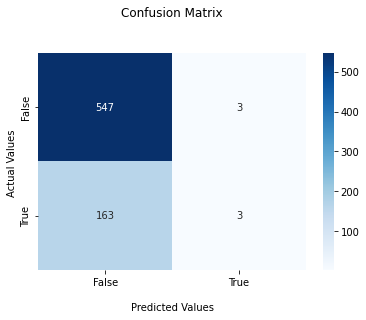

In [24]:
# Multinomial Naive Bayes Classifier
mutlinomial_nb = MultinomialNB()
mutlinomial_nb.fit(X_train, y_train)
print("Training Accuracy:\n{}\n".format(mutlinomial_nb.score(X_train, y_train)))


y_pred = mutlinomial_nb.predict(X_test)

print_training_results(y_test, y_pred)
print_predict_result(y_pred, target_stock, post_target, test_startDate, test_endDate)
print_confusion_martrix(y_test, y_pred)

### KNN & Grid Search

In [25]:
param_test = {"n_neighbors": range(1, 50)}
tuning = GridSearchCV(KNeighborsClassifier(), param_test)
tuning.fit(X_train, y_train)
print(tuning.best_params_['n_neighbors'])

10


Training Accuracy:
0.64067055393586

Stock Trend Predeiction Performance:
              precision    recall  f1-score   support

        Down       0.35      0.07      0.11       166
          Up       0.77      0.96      0.86       550

    accuracy                           0.76       716
   macro avg       0.56      0.51      0.48       716
weighted avg       0.68      0.76      0.69       716

F1 scores:  0.6851995089300631
Precision:  0.6766070824887236
recall: 0.755586592178771

Stock Trend Prediction Accuracy:0.7777777777777778



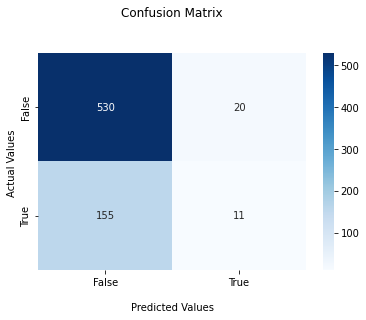

In [26]:
knn_clf = KNeighborsClassifier(n_neighbors=tuning.best_params_['n_neighbors'])
knn_clf.fit(X_train, y_train)
print("Training Accuracy:\n{}\n".format(knn_clf.score(X_train, y_train)))

y_pred = knn_clf.predict(X_test)

print_training_results(y_test, y_pred)
print_predict_result(y_pred, target_stock, post_target, test_startDate, test_endDate)
print_confusion_martrix(y_test, y_pred)

### Gradient Boosting Classifier & Grid Search
- Reference: [Parameter Tuning using gridsearchcv for gradientboosting classifier in python](https://stackoverflow.com/questions/58781601/parameter-tuning-using-gridsearchcv-for-gradientboosting-classifier-in-python)

In [27]:
# Parameter Tuning
param_test = {'learning_rate':[0.01, 0.1, 0.5, 1],    # 0.01, 0.1, 0.2, 0.5, 1 
              'n_estimators':[100, 250],                # 100, 250 ,500 
              'subsample' :[0.1, 0.5, 1.0],
              'max_depth': [3, 5, 7]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features=None, random_state=10), 
            param_grid = param_test, scoring='accuracy',n_jobs=4, cv=5)
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

({'learning_rate': 1, 'max_depth': 7, 'n_estimators': 250, 'subsample': 0.5},
 0.654508294625083)

Training Accuracy:
0.7791545189504373

Stock Trend Predeiction Performance:
              precision    recall  f1-score   support

        Down       0.23      0.28      0.25       166
          Up       0.77      0.73      0.75       550

    accuracy                           0.62       716
   macro avg       0.50      0.50      0.50       716
weighted avg       0.65      0.62      0.63       716

F1 scores:  0.6332441320878428
Precision:  0.6453018250703806
recall: 0.6229050279329609

Stock Trend Prediction Accuracy:0.7777777777777778



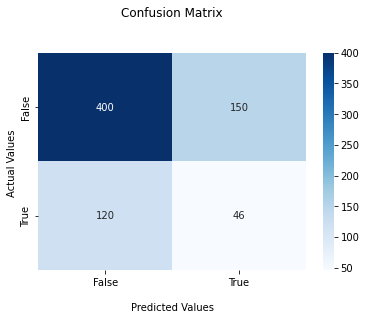

In [28]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, min_samples_split=2, min_samples_leaf=1, subsample=0.1,max_features=None, random_state=10)
clf.fit(X_train, y_train)
print("Training Accuracy:\n{}\n".format(clf.score(X_train, y_train)))

y_pred = clf.predict(X_test)

print_training_results(y_test, y_pred)
print_predict_result(y_pred, target_stock, post_target, test_startDate, test_endDate)
print_confusion_martrix(y_test, y_pred)

In [29]:
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': np.logspace(0.699, 3, num=10, dtype=int),
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'max_features': 'log2', 'n_estimators': 1000}


Training Accuracy:
0.9970845481049563

Stock Trend Predeiction Performance:
              precision    recall  f1-score   support

        Down       0.35      0.17      0.23       166
          Up       0.78      0.91      0.84       550

    accuracy                           0.73       716
   macro avg       0.57      0.54      0.53       716
weighted avg       0.68      0.73      0.70       716

F1 scores:  0.6978733511227451
Precision:  0.6826262253610204
recall: 0.7346368715083798

Stock Trend Prediction Accuracy:0.7777777777777778



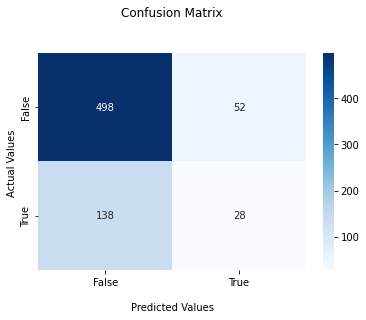

In [30]:
clf = RandomForestClassifier(n_estimators=CV_rfc.best_params_['n_estimators'] , max_features=CV_rfc.best_params_['max_features'], random_state=20)
clf.fit(X_train, y_train)
print("Training Accuracy:\n{}\n".format(clf.score(X_train, y_train)))

y_pred = clf.predict(X_test)

print_training_results(y_test, y_pred)
print_predict_result(y_pred, target_stock, post_target, test_startDate, test_endDate)
print_confusion_martrix(y_test, y_pred)